# Image Super-Resolution Using Deep Convolutional Networks

This notebook is based off of [this paper](https://arxiv.org/pdf/1501.00092v3.pdf)

## Standard Copy Pasted code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
## Install and import torch metrics
!pip install torchmetrics -q
import torchmetrics

!rm DeconvModels.py
!rm training_functions.py
!rm blur_functions.py
!rm Datasets.py
!rm data_augmentation.py

!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/blur_functions.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Datasets/Datasets.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/data_augmentation.py -q

from DeconvModels import Deconv2D, Deconv2D
from training_functions import train_regression_model, train_classification_model
import blur_functions as blur
from Datasets import Div2k
from data_augmentation import RandomCropIsr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 28.7 MB/s eta 0:00:00
rm: cannot remove 'DeconvModels.py': No such file or directory
rm: cannot remove 'training_functions.py': No such file or directory
rm: cannot remove 'blur_functions.py': No such file or directory
rm: cannot remove 'Datasets.py': No such file or directory
rm: cannot remove 'data_augmentation.py': No such file or directory


# Deconv

## Download Dataset

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip -q
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip -q
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X3.zip -q
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip -q

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('DIV2K_train_HR.zip', "r")
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('DIV2K_train_LR_bicubic_X2.zip', "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
hr_path = 'DIV2K_train_HR'
lr_path = 'DIV2K_train_LR_bicubic/X2'

random_crop = RandomCropIsr(96)

data = Div2k(lr_path, hr_path, transform=random_crop, ds_length=20)
dataloader = DataLoader(data, batch_size=4, shuffle=False)

x_batch, y_batch = next(iter(dataloader))

x_batch.size(), y_batch.size()

(torch.Size([4, 1, 48, 48]), torch.Size([4, 1, 96, 96]))

<ipython-input-9-4504b9b8ced8>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


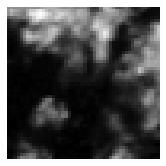

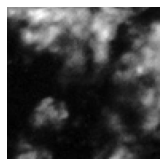

In [ ]:
plt.subplots(2, 1)

plt.subplot(2, 1, 1)
plt.imshow(x_batch[0, 0, :, :], cmap='gray')
plt.axis('off')
plt.show()

plt.subplot(2, 1, 2)
plt.imshow(y_batch[0, 0, :, :], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1, upscale_factor=2, deconv=False):
        super(SRCNN, self).__init__()
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, num_channels * (upscale_factor ** 2), kernel_size=5, padding=2)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU()
        if deconv:
            self.conv1 = Deconv2D((9, 9), 64)
        else:
            self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return x

In [ ]:
channels = x_batch.size(1)
srcnn = SRCNN(channels)

criterion = nn.MSELoss()
optimizer = optim.Adam(srcnn.parameters(), lr=1e-4)

In [ ]:
history, _ = train_regression_model(srcnn, criterion, optimizer, dataloader, num_epochs=30)

Epoch 0001 loss: 1.22390
Epoch 0002 loss: 1.45042
Epoch 0003 loss: 1.43969
Epoch 0004 loss: 1.06844
Epoch 0005 loss: 0.92533
Epoch 0006 loss: 0.88143
Epoch 0007 loss: 0.60698
Epoch 0008 loss: 0.55175
Epoch 0009 loss: 0.40264
Epoch 0010 loss: 0.28813
Epoch 0011 loss: 0.22460
Epoch 0012 loss: 0.14172
Epoch 0013 loss: 0.13446
Epoch 0014 loss: 0.11296
Epoch 0015 loss: 0.09805
Epoch 0016 loss: 0.09621
Epoch 0017 loss: 0.09365
Epoch 0018 loss: 0.11280
Epoch 0019 loss: 0.10956
Epoch 0020 loss: 0.07941
Epoch 0021 loss: 0.08994
Epoch 0022 loss: 0.09472
Epoch 0023 loss: 0.08502
Epoch 0024 loss: 0.09280
Epoch 0025 loss: 0.08103
Epoch 0026 loss: 0.07395
Epoch 0027 loss: 0.07660
Epoch 0028 loss: 0.07456
Epoch 0029 loss: 0.08489
Epoch 0030 loss: 0.06081


Text(0.5, 1.0, 'Original')

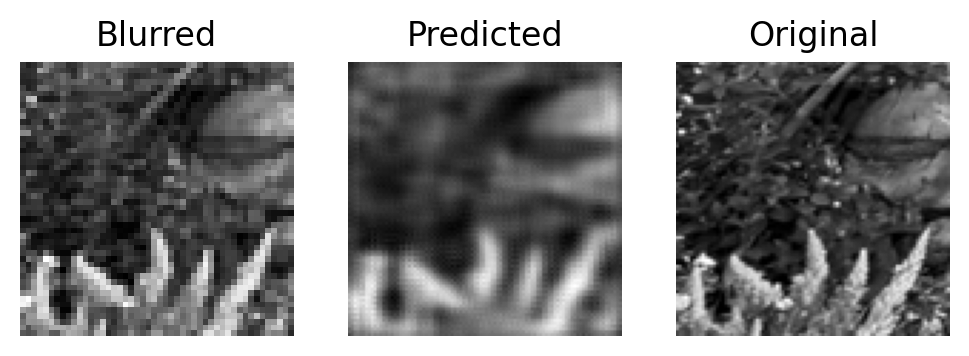

In [ ]:
srcnn = srcnn.to("cpu")
srcnn.eval()
X, y = next(iter(dataloader))

y_pred = srcnn(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,:,:,:].permute(1, 2, 0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Original')

In [ ]:
model_deconv = SRCNN(deconv=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_deconv.parameters(), lr=1e-3)

In [ ]:
history, _ = train_regression_model(model_deconv, criterion, optimizer, dataloader, num_epochs=30)

Epoch 0001 loss: 0.78176
Epoch 0002 loss: 0.35256
Epoch 0003 loss: 0.15442
Epoch 0004 loss: 0.12350
Epoch 0005 loss: 0.11024
Epoch 0006 loss: 0.08515
Epoch 0007 loss: 0.08442
Epoch 0008 loss: 0.07093
Epoch 0009 loss: 0.06163
Epoch 0010 loss: 0.06190
Epoch 0011 loss: 0.04733
Epoch 0012 loss: 0.03844
Epoch 0013 loss: 0.03428
Epoch 0014 loss: 0.03488
Epoch 0015 loss: 0.02868
Epoch 0016 loss: 0.01987
Epoch 0017 loss: 0.03783
Epoch 0018 loss: 0.01658
Epoch 0019 loss: 0.01799
Epoch 0020 loss: 0.02109
Epoch 0021 loss: 0.03114
Epoch 0022 loss: 0.01724
Epoch 0023 loss: 0.01349
Epoch 0024 loss: 0.01335
Epoch 0025 loss: 0.01039
Epoch 0026 loss: 0.01534
Epoch 0027 loss: 0.01080
Epoch 0028 loss: 0.00848
Epoch 0029 loss: 0.00861
Epoch 0030 loss: 0.00828


Text(0.5, 1.0, 'Original')

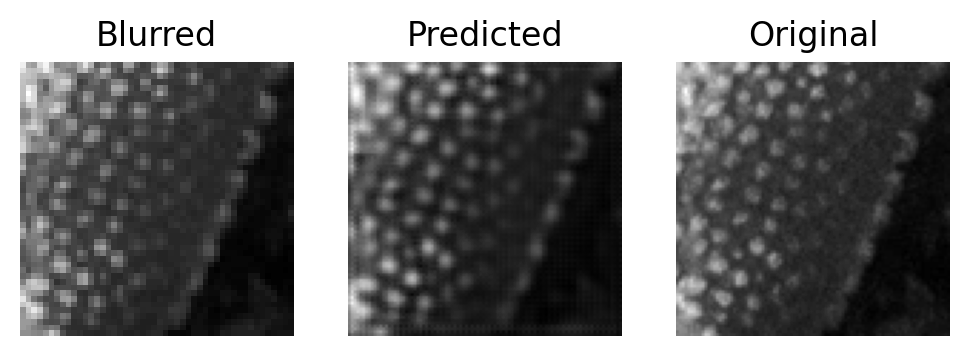

In [ ]:
model_deconv = model_deconv.to("cpu")
model_deconv.eval()
X, y = next(iter(dataloader))

y_pred = model_deconv(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,:,:,:].permute(1, 2, 0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Original')

In [ ]:
print(model_deconv.conv1)
print(srcnn.conv1)

Deconv2D()
Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))


In [ ]:
model_deconv.deconv.w_flat.grad

tensor([-0.0090, -0.0100, -0.0095, -0.0100, -0.0108, -0.0110, -0.0101, -0.0106,
        -0.0108, -0.0101, -0.0089, -0.0088, -0.0088, -0.0078, -0.0066])

Text(0.5, 1.0, 'Predicted SRCNN')

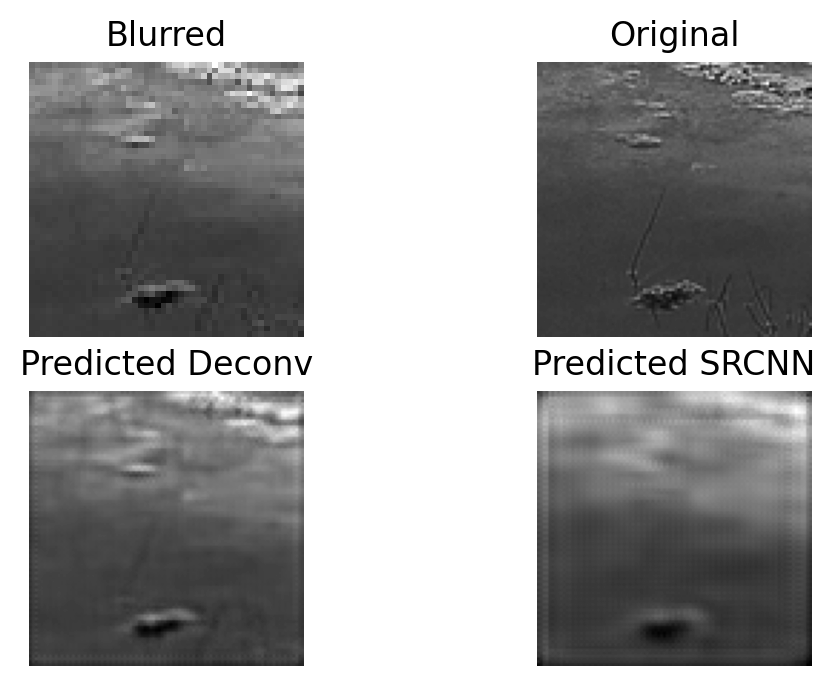

In [ ]:
model_deconv = model_deconv.to("cpu")
model_deconv.eval()
X, y = next(iter(dataloader))

y_pred_deconv = model_deconv(X)
y_pred_srcnn = srcnn(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(2, 2)

plt.subplot(2, 2, 1)
plt.imshow(X[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(2, 2, 2)
plt.imshow(y[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 3)
plt.imshow(y_pred_deconv[i,:,:,:].permute(1, 2, 0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted Deconv')

plt.subplot(2, 2, 4)
plt.imshow(y_pred_srcnn[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted SRCNN')

